# Task 3: XOR Neural Network with the Gradient Descent 

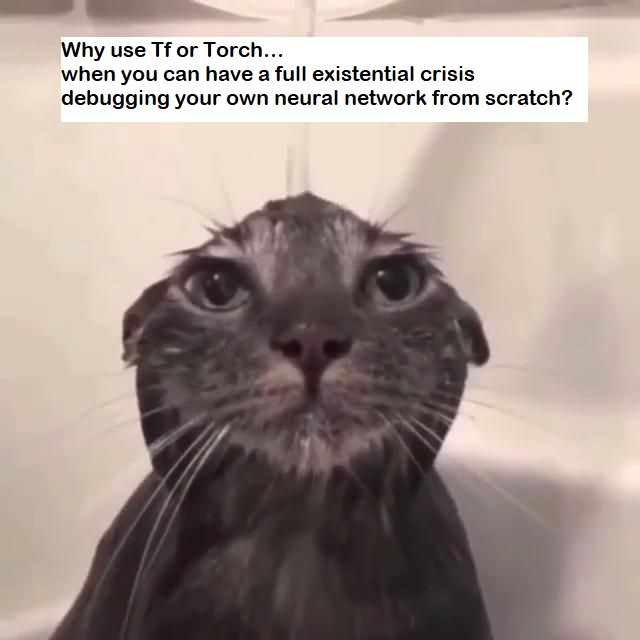

In [1]:
# Big no no to torch and tf here
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Helper functions

# Activation function
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

def sigmoid_derivative(x): # for backprop
    return sigmoid(x) * (1 - sigmoid(x))

# Loss function
def MSE(y, y_hat):
    return np.mean((y_hat - y)**2)

# Weights initialization function
def init_random(input_size, out_size):
    return np.random.randn(input_size, out_size)

In [3]:
# input and output
X = np.array([[0,0],
              [0,1],
              [1,0],
              [1,1]])
y = np.array([[0],
              [1],
              [1],
              [0]])

As we have defined all the necessary ingredients, we can now define our neural network for solving the XOR problem.

In [19]:

class XORNetwork:
    def __init__(self, learning_rate=0.5, loss_function=MSE, g =sigmoid, g_prime = sigmoid_derivative, initialization = init_random):
        self.lr = learning_rate
        self.loss_function = loss_function
        self.g = g
        self.g_prime = g_prime

        # Weight initialization 
        # input -> hidden layer 
        self.w1 = initialization(2, 2)  # 2 inputs -> 2 outputs
        self.b1 = initialization(1, 2)  # 1 input  -> 2 outputs
        # hidden layer -> output
        self.w2 = initialization(2, 1)  # 2 inputs -> 1 output
        self.b2 = initialization(1, 1)  # 1 input  -> 1 output


    def forward(self, X):
        # Here we store the intermediate results to reuse them during backprop

        # hidden layer
        self.z1 = np.dot(X, self.w1) + self.b1
        self.a1 = self.g(self.z1)

        # output layer
        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = sigmoid(self.z2)
        return self.a2
    

    def backward(self, X, y):
        m = len(y) # to average the gradient across the batch

        # output error (2 is lost!)
        dl_da2 = (2/m)*(self.a2 - y) # derivative of the loss w.r.t. the output: dl\da2
        dl_dz2 = dl_da2 * sigmoid_derivative(self.z2) # error term for the second output: dl/dz2 = dl/da2 * da2/dz2 
        dl_dw2 = np.dot(self.a1.T, dl_dz2)  # error term w.r.t. to w2: dl/dw2= (dl/dz2)* (dz2/dw2)
        dl_db2 = np.sum(dl_dz2, axis=0, keepdims=True) # error term w.r.t. to b2: dl/db2= (dl/dz2)* (dz2/db2); dz2/db2 = 1

        # hidden layer error
        dz2_da1 = self.w2 
        dl_dz1 = np.dot(dl_dz2, dz2_da1.T) * self.g_prime(self.z1) # dl/dz1 = dl/dz2 * dz2/da1 * da1/dz1;
        dl_dw1 = np.dot(X.T, dl_dz1)    #dl/dw1= (dl/dz1)* (dz1/dw1)
        dl_db1 = np.sum(dl_dz1, axis=0, keepdims=True) #dl/db1= (dl/dz1)* (dz1/db1)

        # gradient descent update
        self.w2 -= self.lr * dl_dw2
        self.b2 -= self.lr * dl_db2
        self.w1 -= self.lr * dl_dw1
        self.b1 -= self.lr * dl_db1


    def train(self, X, y, epochs=10000, verbose=True):
        losses = []
        n_mistakes = []
        for i in range(epochs):
            y_hat = self.forward(X) # get predictions (logits)
            loss = self.loss_function(y, y_hat) # calculate error
            final_output = (y_hat > 0.5).astype(int) # step function for final comparison
        
            n_mistakes.append(np.sum(final_output != y))
            losses.append(loss)
            self.backward(X, y) # update the weights
            if i % 1000 == 0 and verbose:
                print(f"Epoch {i}, Loss: {loss:.4f}, Number of misclassifications: {n_mistakes[-1]}")
         
        return losses

    def predict(self, X):
        # For evalutaion phase
        y_hat = self.forward(X)
        return (y_hat > 0.5).astype(int)




# Experimentation

Now let's test and experiment with the network we’ve built. First, we’ll try the 'lazy approach,' where we simply randomly reinitialize the weights until, by sheer luck, we find a set that solves the XOR problem.

In [6]:
n_trials = [] # a list of the number tested weight configurations, until a good one was found
n_repetitions = 100

for _ in range(n_repetitions):
    solved = False 
    trial = 0
    while not solved:
        trial += 1
        nn = XORNetwork() # initialize the weight randomly
        y_hat = nn.predict(X) # get predictions
        solved = np.array_equal(y, y_hat)
    n_trials.append(trial) 

print(f"On average {np.mean(n_trials):.2f} random weight configurations should be tested to get a satisfactory one.")

On average 144178.59 random weight configurations should be tested to get a satisfactory one.


As we can see, this approach is highly inefficient, so let’s put our neureal network to the test!

In [14]:
nn = XORNetwork()
losses = nn.train(X, y)


Epoch 0, Loss: 0.2879, Number of misclassifications: 2
Epoch 1000, Loss: 0.2487, Number of misclassifications: 1
Epoch 2000, Loss: 0.1842, Number of misclassifications: 1
Epoch 3000, Loss: 0.0206, Number of misclassifications: 0
Epoch 4000, Loss: 0.0077, Number of misclassifications: 0
Epoch 5000, Loss: 0.0045, Number of misclassifications: 0
Epoch 6000, Loss: 0.0032, Number of misclassifications: 0
Epoch 7000, Loss: 0.0024, Number of misclassifications: 0
Epoch 8000, Loss: 0.0019, Number of misclassifications: 0
Epoch 9000, Loss: 0.0016, Number of misclassifications: 0


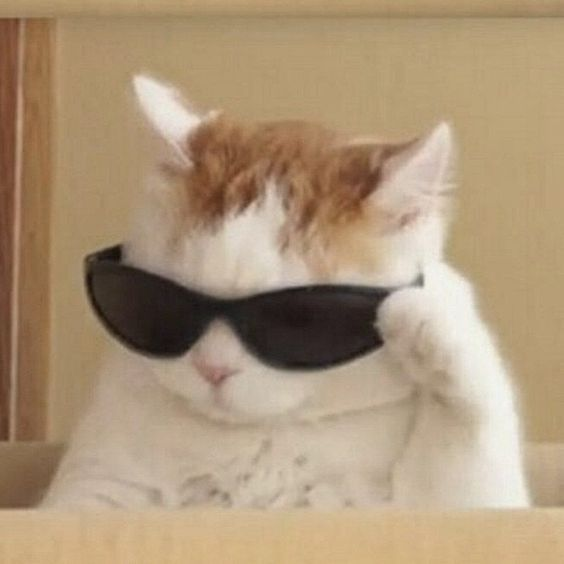


Wow, it works

Now, let’s experiment with different hyperparameters, including learning rate, activation function, and weight initialization strategy.

In [8]:
def plot_losses(loss_dict, name="Hyperparameter"):

    """Creates a plot of learning curves with corresponding 
      confidence intervals for different hyperparameters"""
    
    plt.figure(figsize=(7,5))
    
    for hp_value, (mean_losses, ci) in loss_dict.items():
        epochs = np.arange(1, len(mean_losses) + 1)
        
        # plot the mean 
        plt.plot(epochs, mean_losses, label=f"{hp_value}")
        
        # CI
        plt.fill_between(
            epochs, 
            mean_losses - ci, 
            mean_losses + ci, 
            alpha=0.2
        )
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs (mean ± 95% CI)")
    plt.legend(title=name)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

In [9]:
reps = 100
epochs = 5000

# Learning rate

Testing lr: 0.001
Run: 0/100
Run: 10/100
Run: 20/100
Run: 30/100
Run: 40/100
Run: 50/100
Run: 60/100
Run: 70/100
Run: 80/100
Run: 90/100
Testing lr: 0.01
Run: 0/100
Run: 10/100
Run: 20/100
Run: 30/100
Run: 40/100
Run: 50/100
Run: 60/100
Run: 70/100
Run: 80/100
Run: 90/100
Testing lr: 0.1
Run: 0/100
Run: 10/100
Run: 20/100
Run: 30/100
Run: 40/100
Run: 50/100
Run: 60/100
Run: 70/100
Run: 80/100
Run: 90/100
Testing lr: 0.5
Run: 0/100
Run: 10/100
Run: 20/100
Run: 30/100
Run: 40/100
Run: 50/100
Run: 60/100
Run: 70/100
Run: 80/100
Run: 90/100
Testing lr: 0.7
Run: 0/100
Run: 10/100
Run: 20/100
Run: 30/100
Run: 40/100
Run: 50/100
Run: 60/100
Run: 70/100
Run: 80/100
Run: 90/100
Testing lr: 1
Run: 0/100
Run: 10/100
Run: 20/100
Run: 30/100
Run: 40/100
Run: 50/100
Run: 60/100
Run: 70/100
Run: 80/100
Run: 90/100


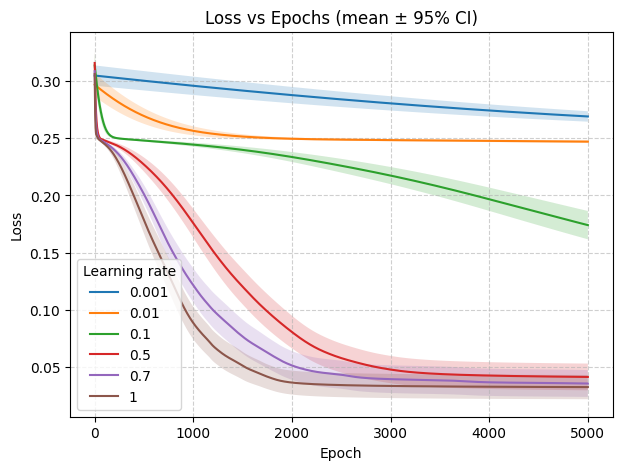

In [10]:
learning_rates = [0.001, 0.01, 0.1, 0.5, 0.7, 1]
all_results = dict()

for lr in learning_rates:
    runs = []
    print(f'Testing lr: {lr}')
    for _ in range(reps):
        if _ % 10 == 0:
            print(f'Run: {_}/{reps}')
        nn = XORNetwork(learning_rate=lr)
        losses = nn.train(X, y, epochs=epochs, verbose=False)
        runs.append(losses)
    
    runs = np.array(runs)  
    mean_losses = runs.mean(axis=0)
    ci = 1.96 * runs.std(axis=0) / np.sqrt(reps)
    all_results[lr] = (mean_losses, ci)

plot_losses(all_results, "Learning rate")


# Activation functions

In [15]:
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

Testing sigmoid
Run: 0/100
Run: 10/100
Run: 20/100
Run: 30/100
Run: 40/100
Run: 50/100
Run: 60/100
Run: 70/100
Run: 80/100
Run: 90/100
Testing tanh
Run: 0/100
Run: 10/100
Run: 20/100
Run: 30/100
Run: 40/100
Run: 50/100
Run: 60/100
Run: 70/100
Run: 80/100
Run: 90/100
Testing relu
Run: 0/100
Run: 10/100
Run: 20/100
Run: 30/100
Run: 40/100
Run: 50/100
Run: 60/100
Run: 70/100
Run: 80/100
Run: 90/100


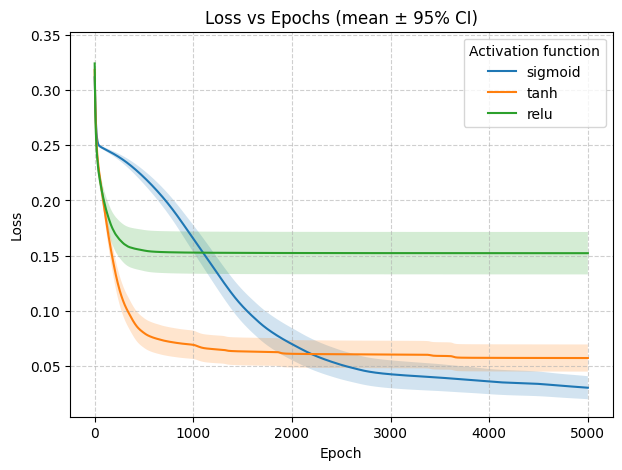

In [21]:
activation_functions =[(sigmoid, sigmoid_derivative), (tanh, tanh_derivative), (relu, relu_derivative)]
reps = 100
epochs = 5000

all_results = dict()

for g, g_prime in activation_functions:
    runs = []
    print(f'Testing {g.__name__}')
    for _ in range(reps):
        if _ % 10 == 0:
            print(f'Run: {_}/{reps}')
        nn = XORNetwork(learning_rate= 0.5, g=g, g_prime= g_prime)
        losses = nn.train(X, y, epochs=epochs, verbose=False)
        runs.append(losses)
    
    runs = np.array(runs)  
    mean_losses = runs.mean(axis=0)
    
    ci = 1.96 * runs.std(axis=0) / np.sqrt(reps)
    all_results[g.__name__] = (mean_losses, ci)

plot_losses(all_results, "Activation function")


# Initialization startegy

Here we have experimented with several popular weight initizalization startegies such as Xavier [1] and He/Kaiming initializations [2].

[1] Glorot X., Bengio Y. Understanding the difficulty of training deep feedforward neural networks //Proceedings of the thirteenth international conference on artificial intelligence and statistics. – JMLR Workshop and Conference Proceedings, 2010. – С. 249-256.

[2] He K. et al. Delving deep into rectifiers: Surpassing human-level performance on imagenet classification //Proceedings of the IEEE international conference on computer vision. – 2015. – С. 1026-1034.

In [ ]:

def init_xavier(input_size, out_size): # more balanced weights: variation is proportianal to the variation of the input/output size
    limit = np.sqrt(6 / (input_size + out_size))
    return np.random.uniform(-limit, limit, size=(input_size, out_size))

def init_he(input_size, out_size):
    return np.random.randn(input_size, out_size) * np.sqrt(2 / input_size) # should work better for ReLU


Testing init_random
Run: 0/100
Run: 10/100
Run: 20/100
Run: 30/100
Run: 40/100
Run: 50/100
Run: 60/100
Run: 70/100
Run: 80/100
Run: 90/100
Testing init_xavier
Run: 0/100
Run: 10/100
Run: 20/100
Run: 30/100
Run: 40/100
Run: 50/100
Run: 60/100
Run: 70/100
Run: 80/100
Run: 90/100
Testing init_he
Run: 0/100
Run: 10/100
Run: 20/100
Run: 30/100
Run: 40/100
Run: 50/100
Run: 60/100
Run: 70/100
Run: 80/100
Run: 90/100


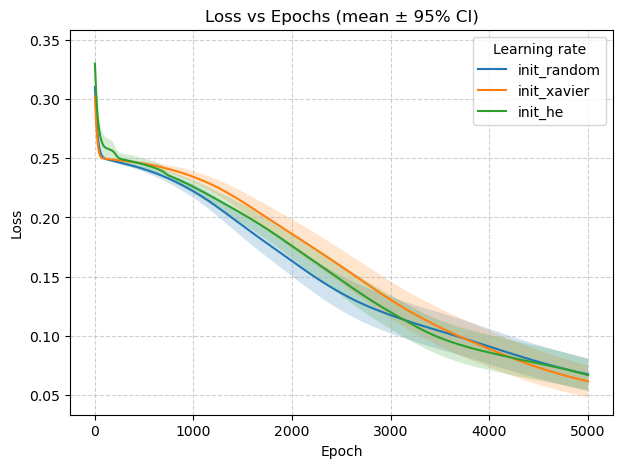

In [ ]:
#  Using sigmoid activation 
init_strategies = [init_random, init_xavier, init_he]
reps = 100
epochs = 5000

all_results = dict()

for init_startegy in init_strategies:
    runs = []
    print(f'Testing {init_startegy.__name__}')
    for _ in range(reps):
        if _ % 10 == 0:
            print(f'Run: {_}/{reps}')
        nn = XORNetwork(initialization=init_startegy)
        losses = nn.train(X, y, epochs=epochs, verbose=False)
        runs.append(losses)
    
    runs = np.array(runs)  
    mean_losses = runs.mean(axis=0)
    
    ci = 1.96 * runs.std(axis=0) / np.sqrt(reps)
    all_results[init_startegy.__name__] = (mean_losses, ci)

plot_losses(all_results, "Learning rate")


Testing init_random
Run: 0/100
Run: 10/100
Run: 20/100
Run: 30/100
Run: 40/100
Run: 50/100
Run: 60/100
Run: 70/100
Run: 80/100
Run: 90/100
Testing init_xavier
Run: 0/100
Run: 10/100
Run: 20/100
Run: 30/100
Run: 40/100
Run: 50/100
Run: 60/100
Run: 70/100
Run: 80/100
Run: 90/100
Testing init_he
Run: 0/100
Run: 10/100
Run: 20/100
Run: 30/100
Run: 40/100
Run: 50/100
Run: 60/100
Run: 70/100
Run: 80/100
Run: 90/100


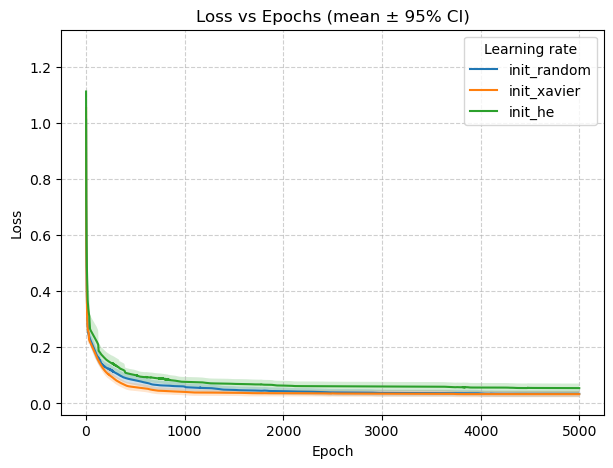

In [ ]:
# Using tanh activation 
init_strategies = [init_random, init_xavier, init_he]
reps = 100
epochs = 5000

all_results = dict()

for init_startegy in init_strategies:
    runs = []
    print(f'Testing {init_startegy.__name__}')
    for _ in range(reps):
        if _ % 10 == 0:
            print(f'Run: {_}/{reps}')
        nn = XORNetwork(initialization=init_startegy, g=tanh, g_prime=tanh_derivative)
        losses = nn.train(X, y, epochs=epochs, verbose=False)
        runs.append(losses)
    
    runs = np.array(runs)  
    mean_losses = runs.mean(axis=0)
    
    ci = 1.96 * runs.std(axis=0) / np.sqrt(reps)
    all_results[init_startegy.__name__] = (mean_losses, ci)

plot_losses(all_results, "Learning rate")
